In [1]:
#Task 1 - Data Loading 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("data/customer_segmntation.csv")
df.head()

,ID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
print(df.isna().sum())
df.dropna(inplace=True)
print(df.isna().sum())
df = df[df['Country']=='United Kingdom']

ID                  0
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
ID             0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [3]:
df['Return']=df.InvoiceNo.str.contains('C')
df['Purchase'] = np.where(df["Return"]==True,0,1)

###### The original dataset was organized long, with invoices nested within customer. Our aim is to create a customer-level dataset and add recency, frequency, and monetary value data to it.

### Calculating Recency

In [4]:
# create new dataframe customer
customers = pd.DataFrame({'CustomerID': df['CustomerID'].unique()},dtype=int)

# calculate the recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Recency'] = pd.to_datetime("2011-12-10") - (df['InvoiceDate'])

# remove the time factor
df.Recency = df.Recency.dt.days

# purchase equal to one 
temp = df[df['Purchase']==1]

# customers latest purchase day
recency=temp.groupby(by='CustomerID',as_index=False).min()
customers=customers.merge(recency[['CustomerID','Recency']],on='CustomerID')
customers.head()

,CustomerID,Recency
0,17850,372
1,13047,31
2,13748,95
3,15100,333
4,15291,25


### Calculating Frequency

In [5]:
temp_1 = df[['CustomerID','InvoiceNo','Purchase']]
temp_1.drop_duplicates(subset=['InvoiceNo'],inplace=True)
annual_invoice = temp_1.groupby('CustomerID',as_index=False).sum()
annual_invoice.rename(columns={'Purchase':'Frequency'},inplace=True)
customers = customers.merge(annual_invoice,on='CustomerID')
customers.head()

,CustomerID,Recency,Frequency
0,17850,372,34
1,13047,31,10
2,13748,95,5
3,15100,333,3
4,15291,25,15


### Calculating Monetary

In [6]:
df['Amount'] = df['Quantity']*df['UnitPrice']
annual_sales = df.groupby('CustomerID',as_index=False).sum()
annual_sales.rename(columns={'Amount':'monetary'},inplace=True)
customers = customers.merge(annual_sales[['CustomerID','monetary']],on='CustomerID')
customers.head()

,CustomerID,Recency,Frequency,monetary
0,17850,372,34,5288.63
1,13047,31,10,3079.10
2,13748,95,5,948.25
3,15100,333,3,635.10
4,15291,25,15,4596.51


In [11]:
customers['monetary'] = np.where(customers['monetary']<0,0,customers['monetary'])
customers['Recency_log'] = np.log(customers['Recency']+0.1)
customers['Frequency_log'] = np.log(customers['Frequency']+0.1)
customers['Monetary_log'] = np.log(customers['monetary']+0.1)

### Elbow method to find optimal number of clusters

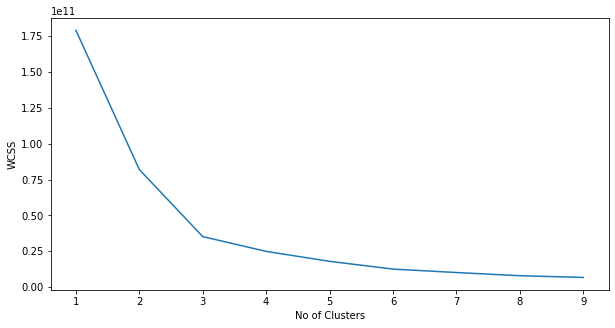

In [32]:
from sklearn.cluster import KMeans
dist = []
for i in range(1,10):
    km = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    km.fit(customers)
    dist.append(km.inertia_)
plt.figure(figsize=(10,5))
plt.plot(range(1, 10),dist)
plt.xlabel("No of Clusters")
plt.ylabel("WCSS")
plt.show()

### Use KMeans to cluster data

<Figure size 720x576 with 0 Axes>

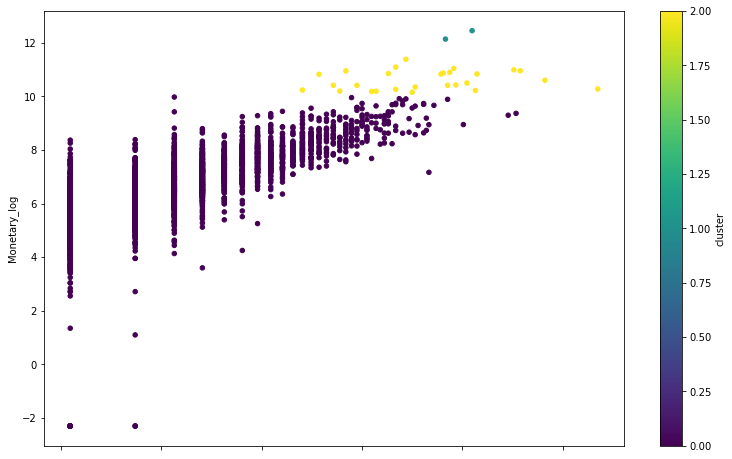

In [70]:
cluster = KMeans(n_clusters=3,init='k-means++',max_iter=300,n_init=10,random_state=0)
customers['cluster'] = cluster.fit_predict(customers.iloc[:,1:7])
plt.figure(figsize=(10,8))
customers.plot.scatter(x= 'Frequency_log',y='Monetary_log',c='cluster',cmap='viridis',figsize=(13,8))
plt.show()

In [51]:
customers.head()

,CustomerID,Recency,Frequency,monetary,Recency_log,Frequency_log,Monetary_log,cluster
0,17850,372,34,5288.63,5.919163,3.529297,8.573333,0
1,13047,31,10,3079.10,3.437208,2.312535,8.032425,0
2,13748,95,5,948.25,4.554929,1.629241,6.854724,0
3,15100,333,3,635.10,5.808443,1.131402,6.453940,0
4,15291,25,15,4596.51,3.222868,2.714695,8.433074,0
